# Data preparation

In [60]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys


# add path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# parent_dir = os.path.dirname(os.path.realpath(__file__))
sys.path.append(parent_dir)
# parent_dir

Try to import the utilities

In [61]:
from src.data.custom_data_module import CustomDataModule
from src.data.custom_dataset import CustomDataset
from src.data.transforms import Normalise

## Description

One simulation consisted of two runs, one for each gravity theory, $\mathtt{T}$:
\begin{equation}
    \mathtt{T} = \{\mathrm{Newton}, \mathrm{GR}\}
\end{equation}
In order to initialise the simulations we used random seeds, one for each simulation. This ensured that analysis performed on different simulations were of different realisations of the simulated universe, essential statistical independence. The seeds, denoted as $\mathtt{S}$ ranged from 0 to 2000, and consisted of the following set:
\begin{equation}
    \{\mathtt{S} \in \mathbb{Z} | 0 \leq \mathtt{S} < 2000 \}
\end{equation}


The output of interest was the density field of the gravitational potential, $\Phi$. This field was outputted at the following redshifts:
\begin{equation}
    z_\mathrm{d} = \{ 20, 15, 10, 5, 1, 0 \}
\end{equation}
One datacube was outputted for each redshift, for each seed, for each gravity theory and denoted $\mathcal{D}_{tzs}$, where $t\in\mathtt{T}$ is the gravity theory, $z\in z_\mathrm{d}$ is the redshift and $s\in\mathtt{S}$ is the seed. This resulted in a total of $N_\mathcal{D}=N_\mathtt{S}N_{z_\mathrm{d}}N_\mathtt{T}=24000$ datacubes, each of size $N_\mathrm{grid}^3$. Each dimension of the datacube can be indexed such that $i,j,k\in[1, N_\mathrm{grid}]$. In this manner, one single data point corresponds to $\mathcal{D}_{tzs}^{ijk}$.

There is however one issue with the redshift, the datacubes produced with the same seed for the same theory, but at different redshifts are highly dependent on each other. This is because they are the same realisations of the universe evolved with the same gravity theory, just evaluated at different times.
In order to have a fully independent set of datacube, I consider only one redshift at a time, and denote the set of datacubes for a given redshift as $\mathcal{D}_z^\mathrm{ind}$. This set consists of $N_\mathcal{D}^\mathrm{ind}=N_\mathcal{D}/N_{z_\mathrm{d}}=4000$ datacubes.

## Statistics

We may start in the vanilla pytorch framework and manually construct a training, validation and test datasets. However, the first thing we need is an instant of the `Normalise` transformation, which can be found [here](../src/data/transforms.py). This function find the mean and standard deviation across all available datacubes and use these values to z-score normalise all data. This ensures that we include the monopole in all of the data. 

The mean of each datacube is $\bar{\mathcal{D}}_{tzs}$ where $t$ is the gravity theory, $z$ is the redshift and $s$ is the seed. 

The statistics of the dataset is evaluated for each independent dataset, i.e. for each redshift.
The mean of one single datacube is therefore explicitly given by:
\begin{equation}
    \bar{\mathcal{D}}_{tzs} = \frac{1}{N_\mathrm{grid}^3}\sum_{i=1}^{N_\mathrm{grid}}\sum_{j=1}^{N_\mathrm{grid}}\sum_{k=1}^{N_\mathrm{grid}}\mathcal{D}_{tzs}^{ijk},
\end{equation}
and the mean of the independent dataset is given by:
\begin{equation}
    \mu_z = \frac{1}{N_\mathcal{D}^\mathrm{ind}}\sum_{t\in\mathtt{T}}\sum_{s\in\mathtt{S}}\bar{\mathcal{D}}_{tzs}.
\end{equation}
The variance of the independence dataset is thus given by:
\begin{equation}
    \mathrm{Var}_z = \frac{1}{N_\mathcal{D}^\mathrm{ind}N_\mathrm{grid}^3}\sum_{t\in\mathtt{T}}\sum_{s\in\mathtt{S}}\sum_i\sum_j\sum_k\left(\mathcal{D}_{tzs}^{ijk} - \mu_z\right)^2,
\end{equation}
and the corresponding standard deviation: 
\begin{equation}
    \sigma_z = \sqrt{\mathrm{Var}_z}.
\end{equation}

## Normalisation

Each independent set of datacubes may then be normalised by subtracting the mean and dividing by the standard deviation. This ensures a zero mean and unit variance across the set, without loosing the monopole and dipole of the data. The normalised datacubes are denoted $\mathcal{D}_z^\mathrm{norm}$ and are given by:
\begin{equation}
    \mathcal{D}_z^\mathrm{norm} = \frac{\mathcal{D}_z^\mathrm{ind} - \mu_z}{\sigma_z},
\end{equation}
which will be the set(s) used for training and testing the machine learning algorithms.

## Trainable dataset

Following this, I extract slices from each datacube, along all axes with a stride $\mathcal{S}$. This will result in a total of $\mathcal{I}_\mathrm{cube}=N_\mathrm{axes}N_\mathrm{grid}/\mathcal{S}$ images per cube, with dimensions $(\mathcal{S}, N_\mathrm{grid}, N_\mathrm{grid})$. The whole dataset will then consist of $\mathcal{I}_\mathrm{tot} = \mathcal{I}_\mathrm{cube}N_\mathrm{cube}$ images.

Given an index $i$ of an image in the dataset, I need to find the corresponding cube, redshift and slice. This is done by the following algorithm, where $i\in[0, \mathcal{I}_\mathrm{tot})$. In the first procedure I find the datacube from the index $i$, and in the second I find the index of the slice corresponding to the desired image for a given datacube.

## Custom dataset in PyTorch

The custom dataset file is [here](../src/data/custom_dataset.py) and we may load it as follows:

In [62]:
data = CustomDataset(
    stride=2,
    redshifts=1.0,
    seeds=np.arange(0,2000,1),
    axes = [0,1,2],
    transform = Normalise(),
    additional_info=True,
)

Some information about the dataset:

In [63]:
print(data)

for i in [0,145,6500, 759872, int(1e6)]:
    data.print_image(i)

Dataset info:
----------------------
  Gravity theories: ['Newton', 'GR']
  Redshifts: [1.0]
  Stride: 2
  Length: 1536000

Image info for seed: 0 where (Newton:0, GR:1):
  label: tensor([0.])
  gravity_theory: newton
  redshift: 1
  seed: 0
  axis: 0
  slice_idx: 0


Image info for seed: 145 where (Newton:0, GR:1):
  label: tensor([0.])
  gravity_theory: newton
  redshift: 1
  seed: 0
  axis: 1
  slice_idx: 17


Image info for seed: 6500 where (Newton:0, GR:1):
  label: tensor([0.])
  gravity_theory: newton
  redshift: 1
  seed: 16
  axis: 2
  slice_idx: 100


Image info for seed: 759872 where (Newton:0, GR:1):
  label: tensor([0.])
  gravity_theory: newton
  redshift: 1
  seed: 1978
  axis: 2
  slice_idx: 64


Image info for seed: 1000000 where (Newton:0, GR:1):
  label: tensor([1.])
  gravity_theory: gr
  redshift: 1
  seed: 604
  axis: 0
  slice_idx: 64




In [64]:
# Function to check if sample has the correct index
# def test_index(dataset, idx):
#     len_tot = len(dataset)
#     sample = dataset[idx]
#     slice_idx = sample['slice_idx']
#     axis = sample['axis']
#     seed = sample['seed']
#     redshift = sample['redshift']
#     gravity_theory = sample['gravity_theory']
    
#     # Calculate the index the sample should have:
#     calc_idx = 0 if gravity_theory == "newton" else len_tot//2    
#     idx_per_redshift = len_tot//(2*dataset.nr_redshifts)
#     redshift_idx = int(np.argwhere(np.array(dataset.redshifts) == float(redshift))[0][0])
#     calc_idx += redshift_idx*idx_per_redshift
    
#     calc_idx += seed * dataset.images_per_cube
    
#     calc_idx += axis * dataset.images_per_axis
    
#     calc_idx += slice_idx 
    
#     if calc_idx != idx:
#         print(f"Error: Index {idx} does not match the calculated index {calc_idx}")
    

In [65]:
from tqdm import tqdm, trange

# test_index(data, 10)
# for idx in trange(0, len(data), 5750):
#     test_index(data, idx)



## Visalise the images

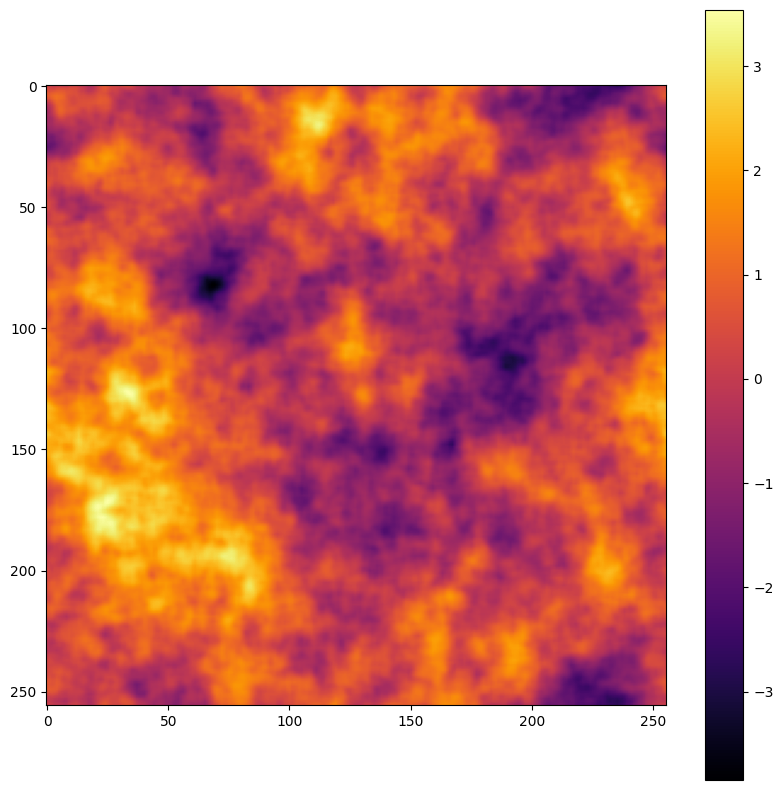

In [66]:
I0 = data[70]['image'].numpy()

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(I0[0,:,:], cmap='inferno')
cbar = plt.colorbar(im, ax=ax)

# Testing loading data with pandas


In [67]:
import time
import pandas
import h5py
from src.utils import paths

In [68]:
dummy_path = paths.get_cube_path(1212, "gr", 1.0)
print(dummy_path)

/mn/stornext/d10/data/johanmkr/simulations/gevolution_first_runs/seed1212/gr/gr_snap004_phi.h5


In [69]:
time_start = time.time()
# load with pandas
# dataframe = pandas.read_hdf(str(dummy_path), key='data')
# H5py
with h5py.File(str(dummy_path), 'r') as f:
    dset= f.get('data')
    dset = np.array(dset)
time_end = time.time()
print(f"Time to load with pandas: {time_end-time_start:.2f}")

Time to load with pandas: 0.04


In [70]:
dset.shape


(256, 256, 256)

# Testing slicing directly when reading h5-files

In [71]:
import torch

In [72]:
seed = 1212
redshift = 1.0
gravity_theory = "gr"
sample_path = paths.get_cube_path(seed, gravity_theory, redshift)

# Old way of reading the code
with h5py.File(sample_path, "r") as f:
    cube_image = torch.tensor(f["data"][()], dtype=torch.float32)


In [73]:
cube_image.shape

torch.Size([256, 256, 256])

In [74]:
stride=2
images_per_axis = 256 // stride
images_per_cube = images_per_axis*3

In [75]:
def find_slice_idx(idx, stride):
    images_per_axis = 256 // stride
    images_per_cube = images_per_axis*3
    slice_idx = idx % images_per_cube
    return slice_idx

In [76]:
def find_slices(slice_idx: int):
        slices = [slice(None)] * 3
        axis = slice_idx // images_per_axis
        idx_on_slice = slice_idx % images_per_axis
        slices[axis] = slice(
            idx_on_slice * stride, (idx_on_slice + 1) * stride
        )
        return tuple(slices)

In [77]:
images_per_cube

384

In [78]:
slice_idx = find_slice_idx(382//3, 2)
someslice = find_slices(slice_idx)
someslice

(slice(254, 256, None), slice(None, None, None), slice(None, None, None))

In [79]:
old_way_slice = cube_image[someslice]
old_way_slice.shape

torch.Size([2, 256, 256])

In [90]:
# Directly slice from dataset:
def load_sample_old(sample_path, slice_idx):
    with h5py.File(sample_path, "r") as f:
        cube_image = torch.tensor(f["data"][()], dtype=torch.float32)
    someslice = find_slices(slice_idx)
    return cube_image[someslice].reshape(stride, 256, 256)

def load_sample_new(sample_path, slice_idx):
    with h5py.File(sample_path, "r") as f:
        cube_image = torch.tensor(f["data"][find_slices(slice_idx)], dtype=torch.float32)
    return cube_image.reshape(stride, 256, 256)


### Check if they are the same array

In [91]:
old_slice = load_sample_old(sample_path, slice_idx)
new_slice = load_sample_new(sample_path, slice_idx)
abs(old_slice - new_slice).max()

tensor(0.)

In [95]:
# Timings for same seed
N = 500
# Old way
time_start = time.time()
for idx in trange(N):
    load_sample_old(sample_path, find_slice_idx(idx, stride=2))
time_end = time.time()
print(f"Time to load with old way: {time_end-time_start:.2f}")
print(f"Time per sample: {(time_end-time_start)/N:.4f}")

# New way
time_start = time.time()
for idx in trange(N):
    load_sample_new(sample_path, find_slice_idx(idx, stride=2))
time_end = time.time()
print(f"Time to load with new way: {time_end-time_start:.2f}")
print(f"Time per sample: {(time_end-time_start)/N:.4f}")

  0%|                                                                                                                                 | 0/500 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 35.30it/s]


Time to load with old way: 14.16
Time per sample: 0.0283


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 29.78it/s]

Time to load with new way: 16.79
Time per sample: 0.0336


In [97]:
# Timings for different seeds
N = 250

seeds = np.arange(0,N,1)
# Old way
time_start = time.time()
for seed in seeds:
    sample_path = paths.get_cube_path(seed, gravity_theory, redshift)
    load_sample_old(sample_path, find_slice_idx(5, stride=2))
time_end = time.time()
print(f"Time to load with old way: {time_end-time_start:.2f}")
print(f"Time per sample: {(time_end-time_start)/N:.4f}")

seeds = np.arange(N, 2*N, 1)
# New way
time_start = time.time()
for seed in seeds:
    sample_path = paths.get_cube_path(seed, gravity_theory, redshift)
    load_sample_new(sample_path, find_slice_idx(5, stride=2))
time_end = time.time()
print(f"Time to load with new way: {time_end-time_start:.2f}")
print(f"Time per sample: {(time_end-time_start)/N:.4f}")



Time to load with old way: 179.62
Time per sample: 0.7185
Time to load with new way: 8.46
Time per sample: 0.0338
